# Machine and Deep Learning for DDoS Detection
### Marcos V. O. Assis (mvoassis@gmail.com)
With the pricey help of:
### Alessandro N. (a.niccolini[at]protonmail.com)
### Giacomo V. ()
***

> ## Published Results:

* *A GRU deep learning system against attacks in software defined networks*

* https://doi.org/10.1016/j.jnca.2020.102942



* \***Update - 05/2023** - Update the packages to the newest one.

> ## Objectives

1. Evaluate different Machine and Deep Learning methods for anomaly detection.
2. Detection of Distributed Denial of Service Attacks

> ## Dataset

* CIC-DDoS2019 - https://www.unb.ca/cic/datasets/ddos-2019.html

> ## Evaluated Methods

* Gated Recurrent Units (GRU)
* Long-Short Term Memory (LSTM)
* Convolutional Neural Network (CNN)
* Deep Neural Network (DNN)
* Support Vector Machine (SVM)
* Logistic Regression (LR)
* Gradient Descent (GD)
* k Nearest Neighbors (kNN)

> ## Environment Config.

* Python 3.11 + the following packages:
    * pandas
    * numpy
    * scikit-learn
    * keras
    * tensorflow
    * seaborn
    * matplotlib

***

# Importing and treating CIC-DDoS-2019

In [2]:
import pandas as pd
import numpy as np
import hashlib
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,GRU,Embedding,Dropout,Flatten,Conv1D,MaxPooling1D,LSTM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from keras.models import model_from_json
from sklearn import preprocessing
from imblearn.metrics import classification_report_imbalanced
import numba as nb

import warnings
    

warnings.filterwarnings('ignore')

## Defining functions to load files and downsample them

As this research aims to develop a binary detector (Attack or Normal), we should balance the dataset between these two classes. However, CIC-DDOS2019 has few normal flows in it. Thus, downsampling is necessary.

For the downsampling process, we allow anomalous flows to be "mult" times bigger than normal flows. This approach aims to reduce class disbalance while preventing information losses on attack flows (when the number of attack flows is downsampled to the number of normal ones, ML models could not fit appropriately).  

In [3]:
mult = 5

def load_file(path):
    data = pd.read_csv(path, sep=',')

    is_benign = data[' Label']=='BENIGN'
    flows_ok = data[is_benign]
    flows_ddos_full = data[~is_benign]
    
    sizeDownSample = len(flows_ok)*mult # final set size of anomalous data
    
    # downsample majority
    if (len(flows_ok)*mult) < (len(flows_ddos_full)): 
        flows_ddos_reduced = resample(flows_ddos_full,
                                         replace = False, # sample without replacement
                                         n_samples = sizeDownSample, # match minority n
                                         random_state = 27) # reproducible results
    else:
        flows_ddos_reduced = flows_ddos_full
    
    return flows_ok, flows_ddos_reduced

 
def load_huge_file(path):
    df_chunk = pd.read_csv(path, chunksize=500000)
    
    chunk_list_ok = []  # append each chunk df here 
    chunk_list_ddos = [] 

    # Each chunk is in df format
    for chunk in df_chunk:  
        # perform data filtering 
        is_benign = chunk[' Label']=='BENIGN'
        flows_ok = chunk[is_benign]
        flows_ddos_full = chunk[~is_benign]
        
        if (len(flows_ok)*mult) < (len(flows_ddos_full)): 
            sizeDownSample = len(flows_ok)*mult # tamanho do set final de dados anomalos
            
            # downsample majority
            flows_ddos_reduced = resample(flows_ddos_full,
                                             replace = False, # sample without replacement
                                             n_samples = sizeDownSample, # match minority n
                                             random_state = 27) # reproducible results 
        else:
            flows_ddos_reduced = flows_ddos_full
            
        # Once the data filtering is done, append the chunk to list
        chunk_list_ok.append(flows_ok)
        chunk_list_ddos.append(flows_ddos_reduced)
        
    # concat the list into dataframe 
    flows_ok = pd.concat(chunk_list_ok)
    flows_ddos = pd.concat(chunk_list_ddos)
    
    return flows_ok, flows_ddos

In [4]:
### Uncomment to download the database
''' Commands for Windows
!curl -o temp.zip http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-01-12.zip
!tar -xf CSV-01-12.zip
!tar -xf CSV-03-11.zip
!del CSV-01-12.zip
!del CSV-03-11.zip'''
''' Commands for Linux
!wget "http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-01-12.zip" -O temp.zip
! unzip temp.zip
! rm temp.zip
'''

' Commands for Linux\n!wget "http://205.174.165.80/CICDataset/CICDDoS2019/Dataset/CSVs/CSV-01-12.zip" -O temp.zip\n! unzip temp.zip\n! rm temp.zip\n'

## Loading CIC-DDoS2019 - Day 1 (training)

In [5]:
# file 1
flows_ok, flows_ddos = load_huge_file('./01-12/TFTP.csv')
print('file 1 loaded')

# file 2
a,b = load_file('./01-12/DrDoS_LDAP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 2 loaded')

# file 3
a,b = load_file('./01-12/DrDoS_MSSQL.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 3 loaded')

# file 4
a,b = load_file('./01-12/DrDoS_NetBIOS.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 4 loaded')

# file 5
a,b = load_file('./01-12/DrDoS_NTP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 5 loaded')

# file 6
a,b = load_file('./01-12/DrDoS_SNMP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 6 loaded')

# file 7
a,b = load_file('./01-12/DrDoS_SSDP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 7 loaded')

# file 8
a,b = load_file('./01-12/DrDoS_UDP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 8 loaded')

# file 9
a,b = load_file('./01-12/Syn.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 9 loaded')

# file 10
a,b = load_file('./01-12/DrDoS_DNS.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 10 loaded')

# file 11
a,b = load_file('./01-12/UDPLag.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 11 loaded')

del a,b

samples = pd.concat([flows_ok, flows_ddos], ignore_index=True)
samples.to_csv(r'./01-12/export_dataframe.csv', index = None, header=True) 

del flows_ddos, flows_ok

file 1 loaded
file 2 loaded
file 3 loaded
file 4 loaded
file 5 loaded
file 6 loaded
file 7 loaded
file 8 loaded
file 9 loaded
file 10 loaded
file 11 loaded


## Loading CIC-DDoS2019 - Day 2 (testing)

In [6]:
# file 1
flows_ok, flows_ddos = load_file('./03-11/LDAP.csv')
print('file 1 loaded')

# file 2
a,b = load_file('./03-11/MSSQL.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 2 loaded')

# file 3
a,b = load_file('./03-11/NetBIOS.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 3 loaded')

# file 4
a,b = load_file('./03-11/PortMap.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 4 loaded')

# file 5
a,b = load_file('./03-11/Syn.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 5 loaded') 

file 1 loaded
file 2 loaded
file 3 loaded
file 4 loaded
file 5 loaded


In [7]:
# following files will load but also cause the following error:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int) **
'''# file 6

a,b = load_huge_file('./03-11/UDP.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 6 loaded')

# file 7
a,b = load_huge_file('./03-11/UDPLag.csv')
flows_ok = pd.concat([flows_ok, a], ignore_index=True) 
flows_ddos = pd.concat([flows_ddos, b], ignore_index=True)
print('file 7 loaded')'''

tests = pd.concat([flows_ok, flows_ddos], ignore_index=True)
tests.to_csv(r'./01-12/export_tests.csv', index = None, header=True) 

del flows_ddos, flows_ok, a, b

### Vissualization pre Pre-Processing

In [8]:
num_features = tests.shape[1]
print("tests -> number of features:", num_features)
num_features = samples.shape[1]
print("samples -> number of features:", num_features)

tests -> number of features: 88
samples -> number of features: 88


## CIC-DDoS2019 Data Processing

In [9]:
# training data
samples = pd.read_csv('./01-12/export_dataframe.csv', sep=',')

def string2numeric_hash(text):
    return int(hashlib.md5(text).hexdigest()[:8], 16)

# Flows Packet/s e Bytes/s - Replace infinity by 0
samples = samples.replace('Infinity','0')
samples = samples.replace(np.inf,0)
#samples = samples.replace('nan','0')
samples[' Flow Packets/s'] = pd.to_numeric(samples[' Flow Packets/s'])

samples['Flow Bytes/s'] = samples['Flow Bytes/s'].fillna(0)
samples['Flow Bytes/s'] = pd.to_numeric(samples['Flow Bytes/s'])


#Label
samples[' Label'] = samples[' Label'].replace('BENIGN',0)
samples[' Label'] = samples[' Label'].replace('DrDoS_DNS',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_LDAP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_MSSQL',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_NTP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_NetBIOS',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_SNMP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_SSDP',1)
samples[' Label'] = samples[' Label'].replace('DrDoS_UDP',1)
samples[' Label'] = samples[' Label'].replace('Syn',1)
samples[' Label'] = samples[' Label'].replace('TFTP',1)
samples[' Label'] = samples[' Label'].replace('UDP-lag',1)
samples[' Label'] = samples[' Label'].replace('WebDDoS',1)

#Timestamp - Drop day, then convert hour, minute and seconds to hashing 
colunaTime = pd.DataFrame(samples[' Timestamp'].str.split(' ').tolist(), columns = ['dia','horas'])
colunaTime = pd.DataFrame(colunaTime['horas'].str.split('.').tolist(),columns = ['horas','milisec'])
stringHoras = pd.DataFrame(colunaTime['horas'].str.encode('utf-8'))
samples[' Timestamp'] = pd.DataFrame(stringHoras['horas'].apply(string2numeric_hash))#colunaTime['horas']
del colunaTime,stringHoras


# flowID - Source IP - Destination IP - Similar HTTP -> Delete (analyze flow by flow)
del samples[' Source IP']
del samples[' Destination IP']
del samples['Flow ID']
del samples['SimillarHTTP']
del samples['Unnamed: 0']

samples.to_csv(r'./01-12/export_dataframe_proc.csv', index = None, header=True) 
print('Training data processed')

Training data processed


In [10]:
# test data
tests = pd.read_csv('./01-12/export_tests.csv', sep=',')

def string2numeric_hash(text):
    return int(hashlib.md5(text).hexdigest()[:8], 16)

# Flows Packet/s e Bytes/s - Change infinity by 0
tests = tests.replace('Infinity','0')
tests = tests.replace(np.inf,0)
#amostras = amostras.replace('nan','0')
tests[' Flow Packets/s'] = pd.to_numeric(tests[' Flow Packets/s'])

tests['Flow Bytes/s'] = tests['Flow Bytes/s'].fillna(0)
tests['Flow Bytes/s'] = pd.to_numeric(tests['Flow Bytes/s'])


#Label
tests[' Label'] = tests[' Label'].replace('BENIGN',0)
tests[' Label'] = tests[' Label'].replace('LDAP',1)
tests[' Label'] = tests[' Label'].replace('NetBIOS',1)
tests[' Label'] = tests[' Label'].replace('MSSQL',1)
tests[' Label'] = tests[' Label'].replace('Portmap',1)
tests[' Label'] = tests[' Label'].replace('Syn',1)
#tests[' Label'] = tests[' Label'].replace('DrDoS_SNMP',1)
#tests[' Label'] = tests[' Label'].replace('DrDoS_SSDP',1)

#Timestamp - Drop day, then convert hour, minute and seconds to hashing 
colunaTime = pd.DataFrame(tests[' Timestamp'].str.split(' ').tolist(), columns = ['dia','horas'])
colunaTime = pd.DataFrame(colunaTime['horas'].str.split('.').tolist(),columns = ['horas','milisec'])
stringHoras = pd.DataFrame(colunaTime['horas'].str.encode('utf-8'))
tests[' Timestamp'] = pd.DataFrame(stringHoras['horas'].apply(string2numeric_hash))#colunaTime['horas']
del colunaTime,stringHoras

# flowID - Source IP - Destination IP - Similar HTTP -> Delete (analyze flow by flow)
del tests[' Source IP']
del tests[' Destination IP']
del tests['Flow ID']
del tests['SimillarHTTP']
del tests['Unnamed: 0']

tests.to_csv(r'./01-12/export_tests_proc.csv', index = None, header=True) 
print('Test data processed')

Test data processed


## Methods implementation

### Gated Recurrent Units (GRU)

In [11]:
#input_size
# -> CIC-DDoS2019 82
# -> CIC-IDS2018 78

def GRU_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(GRU(32, input_shape=(input_size,1), return_sequences=False)) #
    model.add(Dropout(0.5))    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.build()
    print(model.summary())
    
    return model

### Convolutional Neural Network (CNN)

In [12]:
def CNN_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(Conv1D(filters=64, kernel_size=8, activation='relu', input_shape=(input_size,1)))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=32, kernel_size=16, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(2))
    
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Long-Short Term Memory (LSTM)

In [13]:
def LSTM_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(LSTM(32,input_shape=(input_size,1), return_sequences=False))
    model.add(Dropout(0.5))    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Deep Neural Network (DNN)

In [14]:
def DNN_model(input_size):
   
    # Initialize the constructor
    model = Sequential()
    
    model.add(Dense(2, activation='relu', input_shape=(input_size,)))
    #model.add(Dense(100, activation='relu'))   
    #model.add(Dense(40, activation='relu'))
    #model.add(Dense(10, activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())
    
    return model

### Support Vector Machine (SVM)

In [15]:
def SVM():
    return SVC(kernel='linear')

### Logistic Regression (LR)

In [16]:
def LR():
    return LogisticRegression()

### Gradient Descent (GD)

In [17]:
def GD():
    return SGDClassifier()

### k Nearest Neighbors (kNN)

In [18]:
def kNN():
    return KNeighborsClassifier(n_neighbors=3, n_jobs=-1)

# Auxiliar Functions

Implementation of auxiliar functions, such as testing, compiling/training, 3d reshape, etc. 

### train_test(samples)
> Receives a group of samples and split it in train/test sets.

In [19]:
def train_test(samples):
    # Specify the data 
    X=samples.iloc[:,0:(samples.shape[1]-1)]
    
    # Specify the target labels and flatten the array
    #y= np.ravel(amostras.type)
    y= samples.iloc[:,-1]
    
    # Split the data up in train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    return X_train, X_test, y_train, y_test

### normalize_data(X_train,X_test)

> Normalize data between -1 and 1

In [20]:
def normalize_data(X_train,X_test):
    # Define the scaler 
    #scaler = StandardScaler().fit(X_train)
    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    
    # Scale the train set
    X_train = scaler.transform(X_train)
    
    # Scale the test set
    X_test = scaler.transform(X_test)
    
    return X_train, X_test

### format_{2,3}d()

> Reshape data in 3d or 2d format (for input in methods such as GRU, CNN and LSTM)

In [21]:
# Reshape data input

def format_3d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1], 1))

def format_2d(df):
    
    X = np.array(df)
    return np.reshape(X, (X.shape[0], X.shape[1]))

### compile_train(model,X_train,y_train,deep=True)

> Compile and train learning model

> deep = False for scikit-learn ML methods


In [22]:
def compile_train(model,model_name,X_train,y_train,deep=True):
    
    if(deep==True):

        model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        history = model.fit(X_train, y_train,epochs=10, batch_size=256, verbose=1)
        #model.fit(X_train, y_train,epochs=3)

        # summarize history for accuracy
        if 'acc' in history.history:
            plt.plot(history.history['acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train'], loc='upper left')
            plt.show()
        # summarize history for loss
        if 'loss' in history.history:
            plt.plot(history.history['loss'])
            plt.title('Model loss of ' + model_name)
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train'], loc='upper left')
            plt.show()

        print(model.metrics_names)
    
    else:
        model.fit(X_train, y_train) #SVM, LR, GD
    
    print('Model Compiled and Trained')
    return model


### testes(model,X_test,y_test,y_pred, deep=True)

> Testing performance outcomes of the methods

> deep = False for scikit-learn ML methods


In [23]:
# Testing performance outcomes of the methods

def testes(model,X_test,y_test,y_pred, deep=True):
    if(deep==True): 
        score = model.evaluate(X_test, y_test,verbose=1)

        print(score)
    
    # Alguns testes adicionais
    #y_test = formatar2d(y_test)
    #y_pred = formatar2d(y_pred)
    
    
    # Accuracy 
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)
    
    # Precision 
    prec = precision_score(y_test, y_pred)#,average='macro')
    print('\nPrecision')
    print(prec)
    
    # Recall
    rec = recall_score(y_test, y_pred) #,average='macro')
    print('\nRecall')
    print(rec)
    
    # F1 score
    f1 = f1_score(y_test,y_pred) #,average='macro')
    print('\nF1 Score')
    print(f1)
    
    # Average
    avrg = (acc+prec+rec+f1)/4
    print('\nAverage (acc, prec, rec, f1)')
    print(avrg)
    
    return acc, prec, rec, f1, avrg

### test_normal_atk(y_test,y_pred):

> Calculate the correct classification rate of normal and attack flow records

In [24]:
def test_normal_atk(y_test,y_pred):
    df = pd.DataFrame()
    df['y_test'] = y_test
    df['y_pred'] = y_pred
    
    normal = len(df.query('y_test == 0'))
    atk = len(y_test)-normal
    
    wrong = df.query('y_test != y_pred')
    
    normal_detect_rate = (normal - wrong.groupby('y_test').count().iloc[0][0]) / normal
    atk_detect_rate = (atk - wrong.groupby('y_test').count().iloc[1][0]) / atk
    
    #print(normal_detect_rate,atk_detect_rate)
    
    return normal_detect_rate, atk_detect_rate
    

### Saving and Loading methods

> Methods for saving and loading trained models

In [25]:
# Save model and weights

def save_model(model,name):
    
    arq_json = 'Models/' + name + '.json'
    model_json = model.to_json()
    with open(arq_json,"w") as json_file:
        json_file.write(model_json)
    
    arq_h5 = 'Models/' + name + '.h5'
    model.save_weights(arq_h5)
    print('Model Saved')
    
def load_model(name):
    
    arq_json = 'Models/' + name + '.json'
    json_file = open(arq_json,'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    
    arq_h5 = 'Models/' + name + '.h5'
    loaded_model.load_weights(arq_h5)
    
    print('Model loaded')
    
    return loaded_model

def save_Sklearn(model,nome):
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'wb') as file:
        pickle.dump(model,file)
    print('Model sklearn saved')

def load_Sklearn(nome):
    arquivo = 'Models/'+ nome + '.pkl'
    with open(arquivo,'rb') as file:
        model = pickle.load(file)
    print('Model sklearn loaded')
    return model

# Main script for testing the learning methods

> **Dataset - CIC-DDoS2019**

Loading training dataset (day 1), upsampling normal flows for balancing the training set. 

In [26]:
# UPSAMPLE OF NORMAL FLOWS
    
samples = pd.read_csv('./01-12/export_dataframe_proc.csv', sep=',')

X_train, X_test, y_train, y_test = train_test(samples)


# join again to increase the number of norms
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
is_benign = X[' Label']==0 # all-in-one database

normal = X[is_benign]
ddos = X[~is_benign]

# upsample minority
normal_upsampled = resample(normal,
                          replace=True, # sample with replacement
                          n_samples=len(ddos), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([normal_upsampled, ddos])

# Specify the data 
X_train=upsampled.iloc[:,0:(upsampled.shape[1]-1)]    #DDoS
y_train= upsampled.iloc[:,-1]  #DDoS

input_size = (X_train.shape[1], 1)

del X, normal_upsampled, ddos, upsampled, normal #, l1, l2 

Importing the test dataset (day 2) and normalizing data.

In [27]:
tests = pd.read_csv('./01-12/export_tests_proc.csv', sep=',')

# X_test = np.concatenate((X_test,(tests.iloc[:,0:(tests.shape[1]-1)]).to_numpy())) # test 33% + test day
# y_test = np.concatenate((y_test,tests.iloc[:,-1]))

del X_test,y_test                         
X_test = tests.iloc[:,0:(tests.shape[1]-1)]                        
y_test = tests.iloc[:,-1]

# print((y_test.shape))
# print((X_test.shape))

X_train, X_test = normalize_data(X_train,X_test)


### Vissualization Post Pre-Processing

In [28]:
num_features = tests.shape[1]
print("tests -> number of features:", num_features)
num_features = samples.shape[1]
print("samples -> number of features:", num_features)

tests -> number of features: 83
samples -> number of features: 83


In [29]:
tests.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298578 entries, 0 to 298577
Data columns (total 83 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Source Port                  298578 non-null  int64  
 1    Destination Port             298578 non-null  int64  
 2    Protocol                     298578 non-null  int64  
 3    Timestamp                    298578 non-null  int64  
 4    Flow Duration                298578 non-null  int64  
 5    Total Fwd Packets            298578 non-null  int64  
 6    Total Backward Packets       298578 non-null  int64  
 7   Total Length of Fwd Packets   298578 non-null  float64
 8    Total Length of Bwd Packets  298578 non-null  float64
 9    Fwd Packet Length Max        298578 non-null  float64
 10   Fwd Packet Length Min        298578 non-null  float64
 11   Fwd Packet Length Mean       298578 non-null  float64
 12   Fwd Packet Length Std        298578 non-nul

In [30]:
null_count = tests.isnull().sum()
print(null_count)

 Source Port         0
 Destination Port    0
 Protocol            0
 Timestamp           0
 Flow Duration       0
                    ..
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Inbound             0
 Label               0
Length: 83, dtype: int64


In [31]:
tests.sample(10)

,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
86183,27804,5971,17,3284847794,1,2,0,1122.0,0.0,561.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
244083,23139,51627,6,3567585503,1,2,0,12.0,0.0,6.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
230073,33478,7815,17,3777910789,3,2,0,804.0,0.0,402.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
30033,61521,443,6,3984748341,1,2,0,37.0,0.0,31.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0
224374,46005,18027,6,1017602862,114,2,2,12.0,12.0,6.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
169829,7900,2339,6,3588018905,1,2,0,12.0,0.0,6.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
257834,5288,2167,6,3462863336,108,2,2,12.0,12.0,6.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
291514,52833,52833,6,2990525710,53325225,14,8,84.0,48.0,6.0,...,73.5,56.372866,116.0,1.0,8.887464e+06,3.205696e+06,13864469.0,6140273.0,1,1
215108,51409,32127,6,1017602862,1,2,0,12.0,0.0,6.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,1,1
7760,50828,53,17,686475253,20862,2,2,84.0,116.0,42.0,...,0.0,0.000000,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0,0


In [32]:
null_count = samples.isnull().sum()
print(null_count)

 Source Port         0
 Destination Port    0
 Protocol            0
 Timestamp           0
 Flow Duration       0
                    ..
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Inbound             0
 Label               0
Length: 83, dtype: int64


In [ ]:
samples.sample(10)

,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
118114,41187,10729,17,1546898973,9016177,8,0,4128.0,0.0,516.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
188765,55738,51488,17,2341517911,2,2,0,926.0,0.0,463.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
99011,62644,64088,17,1184513954,15014725,12,0,6192.0,0.0,516.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
307272,1019,35057,17,3731775746,1,2,0,2944.0,0.0,1472.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
80459,62583,2011,17,3630113326,3001884,4,0,2064.0,0.0,516.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
252289,794,39293,17,3186855131,49999,176,0,77440.0,0.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
250413,611,3401,17,537762227,11562,8,0,3520.0,0.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
233536,813,35064,17,3072256426,2112,26,0,10720.0,0.0,440.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
46055,57545,80,6,280745201,174133,2,2,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
134998,62502,45621,17,2593743318,18002274,14,0,7224.0,0.0,516.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [ ]:
print(tests.columns)


Index([' Source Port', ' Destination Port', ' Protocol', ' Timestamp',
       ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packe

In [80]:
import plotly.express as px
# Remove leading whitespace from column name
tests.columns = tests.columns.str.strip()

# Create label_counter DataFrame
label_counter1 = pd.DataFrame(tests['Label'].value_counts())

# Print the DataFrame
print(label_counter1)
fig = px.bar(label_counter1, x=label_counter1.index, y=label_counter1['count'])

fig.update_layout(
    title={
        'text': 'Data of Day 1',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title="Label",
    yaxis_title="Instances"
)

# Define the colors for the left and right columns
fig.data[0].marker.color = ['red' if label == label_counter1.index[0] else 'green' for label in label_counter1.index]

fig.show()

        count
Label        
1      248815
0       49763


In [81]:
# Remove leading whitespace from column name
samples.columns = samples.columns.str.strip()

# Create label_counter DataFrame
label_counter2 = pd.DataFrame(samples['Label'].value_counts())

# Print the DataFrame
print(label_counter2)
fig = px.bar(label_counter2, x=label_counter2.index, y=label_counter2['count'])

fig.update_layout(
    title={
        'text': 'Data of Day 1',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title="Label",
    yaxis_title="Instances"
)

# Define the colors for the left and right columns
fig.data[0].marker.color = ['red' if label == label_counter1.index[0] else 'green' for label in label_counter1.index]

fig.show()

        count
Label        
1      275016
0       56863


Compiling and Training the methods

> Comment the last 2 code blocks

**OR**

Loading and compiling the methods

> Comment the first 2 code blocks

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 32)                3360      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                330       
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)             

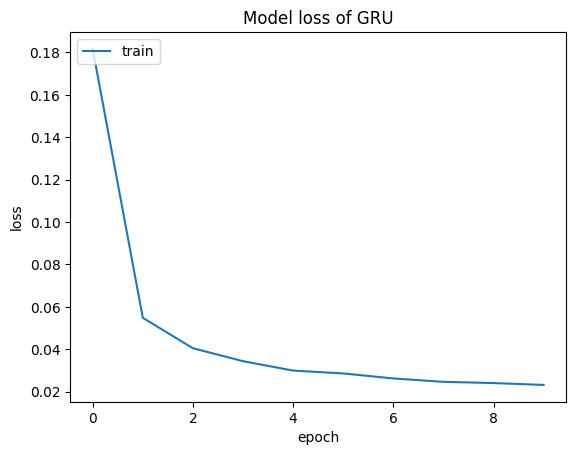

['loss', 'accuracy']
Model Compiled and Trained


In [112]:
## Comment next 2 blocks if loading pre-trained models
## Execute them if training new models
'''model_gru = GRU_model(82) # when it train new model
model_gru.summary()
model_gru = compile_train(model_gru,"GRU",format_3d(X_train),y_train) '''

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 75, 64)            576       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 37, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 22, 32)            32800     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 9, 16)             1552      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 4, 16)           

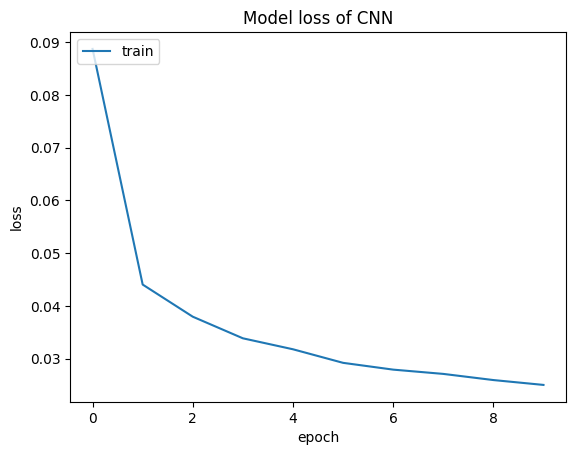

['loss', 'accuracy']
Model Compiled and Trained


In [113]:
'''model_cnn = CNN_model(82)
model_cnn = compile_train(model_cnn,"CNN",format_3d(X_train),y_train)'''

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                330       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,693
Trainable params: 4,693
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1440/1440 [==============================] - 129s 88ms/step - loss: 0.1427 - accuracy: 0.9512
Epoch 2/10
1440/1440 [==============================] - 130s 90ms/step - l

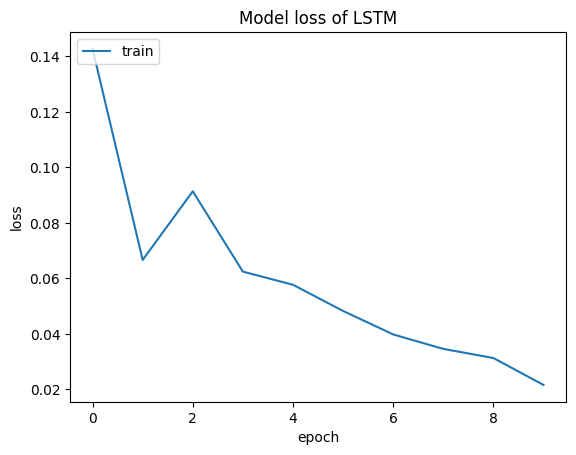

['loss', 'accuracy']
Model Compiled and Trained


In [114]:
'''model_lstm = LSTM_model(82)
model_lstm = compile_train(model_lstm,"LSTM",format_3d(X_train),y_train)'''

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 2)                 166       
                                                                 
 dense_19 (Dense)            (None, 1)                 3         
                                                                 
Total params: 169
Trainable params: 169
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1440/1440 [==============================] - 2s 1ms/step - loss: 0.2826 - accuracy: 0.9617
Epoch 2/10
1440/1440 [==============================] - 1s 932us/step - loss: 0.1306 - accuracy: 0.9874
Epoch 3/10
1440/1440 [==============================] - 1s 935us/step - loss: 0.0896 - accuracy: 0.9876
Epoch 4/10
1440/1440 [==============================] - 1s 945us/step - loss: 0.0723 - accuracy: 0.9883
Epoch 5/10
1440/1440 [===========

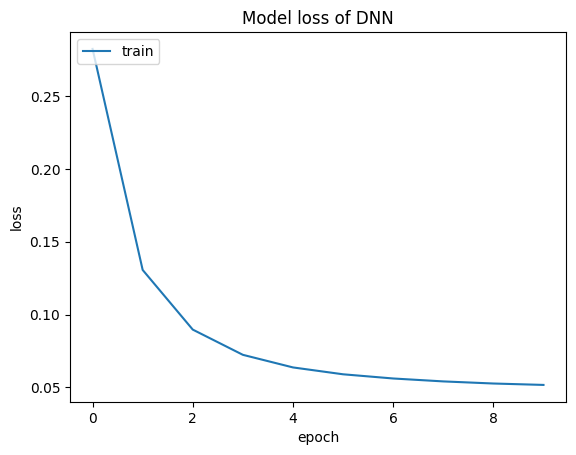

['loss', 'accuracy']
Model Compiled and Trained


In [115]:
'''model_dnn = DNN_model(X_train.shape[1])
model_dnn = compile_train(model_dnn,"DNN",X_train,y_train)'''

In [116]:
'''model_svm = SVM()
model_svm = compile_train(model_svm,"SVM",X_train,y_train,False)'''

Model Compiled and Trained


In [117]:
'''model_lr = LR()
model_lr = compile_train(model_lr,"LR",X_train,y_train,False)'''

Model Compiled and Trained


In [118]:
'''model_gd = GD()
model_gd = compile_train(model_gd,"GD",X_train,y_train,False)'''

Model Compiled and Trained


In [119]:
'''model_knn = kNN()
model_knn = compile_train(model_knn,"KNN",X_train,y_train,False)'''

Model Compiled and Trained


#### Loading Models

In [82]:
## Comment next 2 blocks if training new models
## Execute them if loading pre-trained models

model_gru = load_model('GRU20-32-b256') # when loading previously saved trained model and weights
model_cnn = load_model('CNN5-3cam-b2560')
model_lstm = load_model('LSTM5-32-b256')
model_dnn = load_model('DNN5-2560')
model_svm = load_Sklearn('SVM')
model_lr = load_Sklearn('LR')
model_gd = load_Sklearn('GD')
model_knn = load_Sklearn('kNN-1viz')

model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model loaded
Model loaded
Model loaded
Model loaded
Model sklearn loaded
Model sklearn loaded
Model sklearn loaded
Model sklearn loaded


#### Save Models

In [121]:
# Comment if you wan't to save your models
'''save_model(model_gru, 'GRU20-32-b256')
save_model(model_cnn, 'CNN5-3cam-b2560')
save_model(model_lstm, 'LSTM5-32-b256')
save_model(model_dnn, 'DNN5-2560')
save_Sklearn(model_svm, 'SVM')
save_Sklearn(model_lr, 'LR')
save_Sklearn(model_gd, 'GD')
save_Sklearn(model_knn, 'kNN-1viz')'''


Model Saved
Model Saved
Model Saved
Model Saved
Model sklearn saved
Model sklearn saved
Model sklearn saved
Model sklearn saved


# Testing CIC-DDoS2019 

In [83]:
results = pd.DataFrame(columns=['Method','Accuracy','Precision','Recall', 'F1_Score', 'Average','Normal_Detect_Rate','Atk_Detect_Rate'])

### GRU

In [84]:
y_pred = model_gru.predict(format_3d(X_test)) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_gru,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method': 'GRU',
                          'Accuracy': acc,
                          'Precision': prec,
                          'F1_Score': f1,
                          'Recall': rec,
                          'Average': avrg,
                          'Normal_Detect_Rate': norm,
                          'Atk_Detect_Rate': atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)

9331/9331 [==============================] - 70s 7ms/step - loss: 0.0312 - accuracy: 0.9939
[0.031175224110484123, 0.9939111471176147]

Accuracy
0.993911138797902

Precision
0.9937234395551238

Recall
0.9990032755259932

F1 Score
0.9963563629367154

Average (acc, prec, rec, f1)
0.9957485542039336



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       0.99      0.97      1.00      0.98      0.98      0.96     49763
        Bad       0.99      1.00      0.97      1.00      0.98      0.97    248815

avg / total       0.99      0.99      0.97      0.99      0.98      0.97    298578


CONFUSION MATRIX


<Axes: >

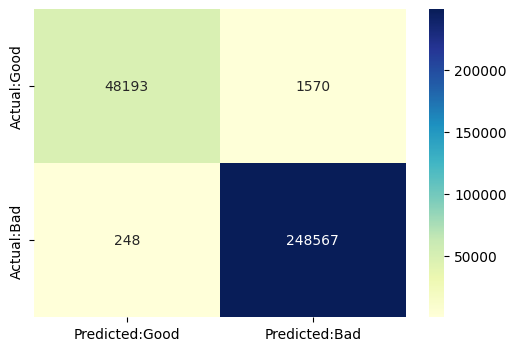

In [86]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### CNN

In [87]:
y_pred = model_cnn.predict(format_3d(X_test)) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_cnn,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'CNN', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)

9331/9331 [==============================] - 38s 4ms/step - loss: 0.0244 - accuracy: 0.9874
[0.024435434490442276, 0.987410306930542]

Accuracy
0.9874103249402166

Precision
0.990233577927326

Recall
0.9947028917066897

F1 Score
0.9924632032288528

Average (acc, prec, rec, f1)
0.9912024994507712



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       0.97      0.95      0.99      0.96      0.97      0.94     49763
        Bad       0.99      0.99      0.95      0.99      0.97      0.95    248815

avg / total       0.99      0.99      0.96      0.99      0.97      0.95    298578


CONFUSION MATRIX


<Axes: >

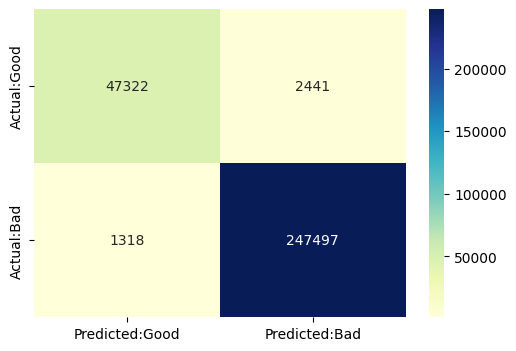

In [88]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### LSTM

In [89]:
y_pred = model_lstm.predict(format_3d(X_test))

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_lstm,format_3d(X_test),y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'LSTM', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


9331/9331 [==============================] - 65s 7ms/step - loss: 0.0203 - accuracy: 0.9980
[0.020341472700238228, 0.9979837536811829]

Accuracy
0.9979837764336288

Precision
0.9992557817710784

Recall
0.9983240560255612

F1 Score
0.9987897016071636

Average (acc, prec, rec, f1)
0.998588328959358



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       0.99      1.00      1.00      0.99      1.00      0.99     49763
        Bad       1.00      1.00      1.00      1.00      1.00      0.99    248815

avg / total       1.00      1.00      1.00      1.00      1.00      0.99    298578


CONFUSION MATRIX


<Axes: >

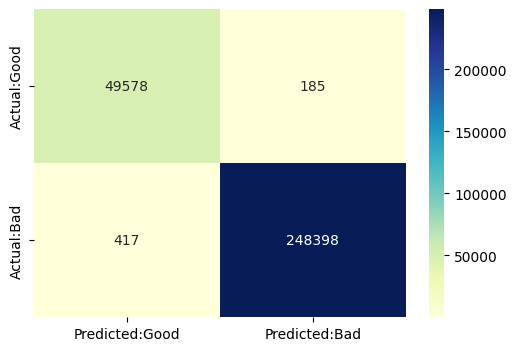

In [90]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### DNN

In [91]:
y_pred = model_dnn.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_dnn,X_test,y_test,y_pred)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'DNN', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)

9331/9331 [==============================] - 6s 672us/step - loss: 0.0629 - accuracy: 0.9979
[0.0628826916217804, 0.9979168176651001]

Accuracy
0.9979167922619885

Precision
0.9982934673931811

Recall
0.9992082470912124

F1 Score
0.9987506477750684

Average (acc, prec, rec, f1)
0.9985422886303627



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       1.00      0.99      1.00      0.99      1.00      0.99     49763
        Bad       1.00      1.00      0.99      1.00      1.00      0.99    248815

avg / total       1.00      1.00      0.99      1.00      1.00      0.99    298578


CONFUSION MATRIX


<Axes: >

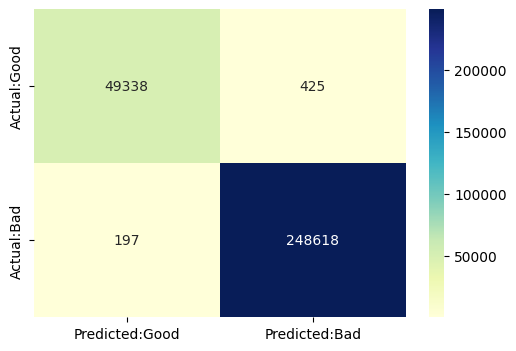

In [92]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### SVM

In [93]:
y_pred = model_svm.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_svm,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'SVM', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9986502689414491

Precision
0.9991480332427783

Recall
0.9992323613930029

F1 Score
0.9991901955386405

Average (acc, prec, rec, f1)
0.9990552147789676



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       1.00      1.00      1.00      1.00      1.00      0.99     49763
        Bad       1.00      1.00      1.00      1.00      1.00      1.00    248815

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    298578


CONFUSION MATRIX


<Axes: >

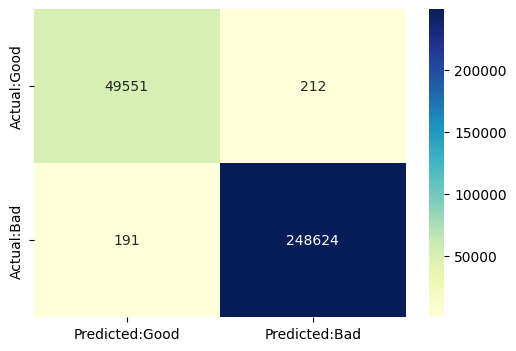

In [94]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### LR

In [95]:
y_pred = model_lr.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_lr,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'LR', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9973005378828983

Precision
0.9990060482167217

Recall
0.9977533508831863

F1 Score
0.9983793066006056

Average (acc, prec, rec, f1)
0.998109810895853



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       0.99      1.00      1.00      0.99      1.00      0.99     49763
        Bad       1.00      1.00      1.00      1.00      1.00      0.99    248815

avg / total       1.00      1.00      1.00      1.00      1.00      0.99    298578


CONFUSION MATRIX


<Axes: >

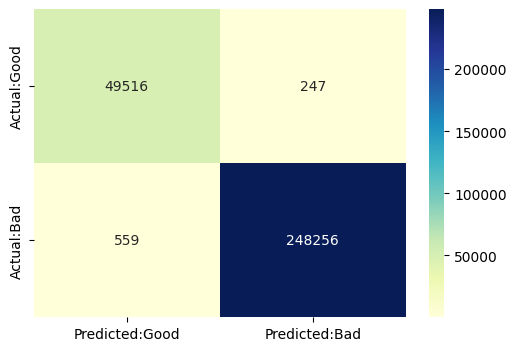

In [96]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### GB

In [97]:
y_pred = model_gd.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_gd,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'GB', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9986770626101052

Precision
0.9991881812043855

Recall
0.999224323292406

F1 Score
0.9992062519215736

Average (acc, prec, rec, f1)
0.9990739547571177



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       1.00      1.00      1.00      1.00      1.00      0.99     49763
        Bad       1.00      1.00      1.00      1.00      1.00      1.00    248815

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    298578


CONFUSION MATRIX


<Axes: >

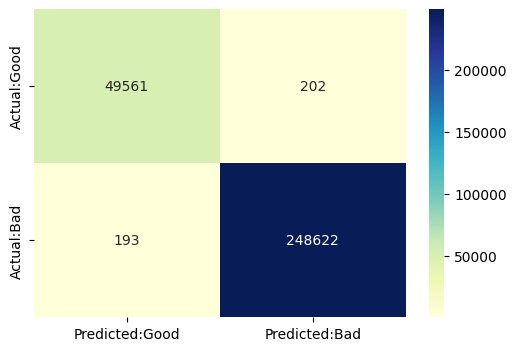

In [98]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### kNN

In [99]:
y_pred = model_knn.predict(X_test) 

y_pred = y_pred.round()
 
acc, prec, rec, f1, avrg = testes(model_knn,X_test,y_test,y_pred,False)

norm, atk = test_normal_atk(y_test,y_pred)

# create a DataFrame from the dictionary
result_df = pd.DataFrame({'Method':'kNN', 'Accuracy':acc, 'Precision':prec, 'F1_Score':f1,
                          'Recall':rec,'Average':avrg, 'Normal_Detect_Rate':norm, 'Atk_Detect_Rate':atk}, index=[0])

# concatenate the new DataFrame with the existing results DataFrame
results = pd.concat([results, result_df], ignore_index=True)


Accuracy
0.9987038562787613

Precision
0.999549571288387

Recall
0.998894761167936

F1 Score
0.9992220589506439

Average (acc, prec, rec, f1)
0.9990925619214321



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

       Good       0.99      1.00      1.00      1.00      1.00      1.00     49763
        Bad       1.00      1.00      1.00      1.00      1.00      1.00    248815

avg / total       1.00      1.00      1.00      1.00      1.00      1.00    298578


CONFUSION MATRIX


<Axes: >

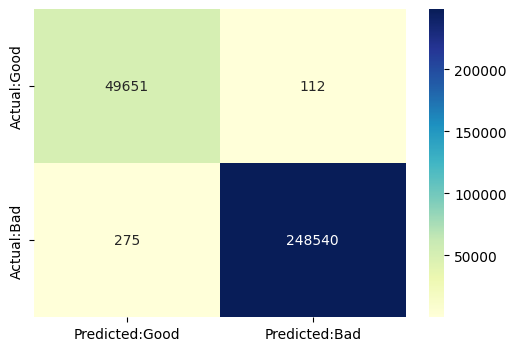

In [100]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Good', 'Predicted:Bad'],
            index = ['Actual:Good', 'Actual:Bad'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Good','Bad']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

# Discussion and Results

Showing the table 'results', containing the performance metrics outcomes for each method.

In [101]:
results

,Method,Accuracy,Precision,Recall,F1_Score,Average,Normal_Detect_Rate,Atk_Detect_Rate
0,GRU,0.993911,0.993723,0.999003,0.996356,0.995749,0.968450,0.999003
1,CNN,0.987410,0.990234,0.994703,0.992463,0.991202,0.950947,0.994703
2,LSTM,0.997984,0.999256,0.998324,0.998790,0.998588,0.996282,0.998324
3,DNN,0.997917,0.998293,0.999208,0.998751,0.998542,0.991460,0.999208
4,SVM,0.998650,0.999148,0.999232,0.999190,0.999055,0.995740,0.999232
5,LR,0.997301,0.999006,0.997753,0.998379,0.998110,0.995036,0.997753
6,GB,0.998677,0.999188,0.999224,0.999206,0.999074,0.995941,0.999224
7,kNN,0.998704,0.999550,0.998895,0.999222,0.999093,0.997749,0.998895


**Classification Metrics:**
* Accuracy
* Precision
* Recall
* F1 Measure (F1 Score)

Showing performance outcomes of the methods: 
* GRU
* DNN
* SVM
* LR
* GB
* kNN

LSTM and CNN were separated for visualization improvement.

In [144]:
sns.set()

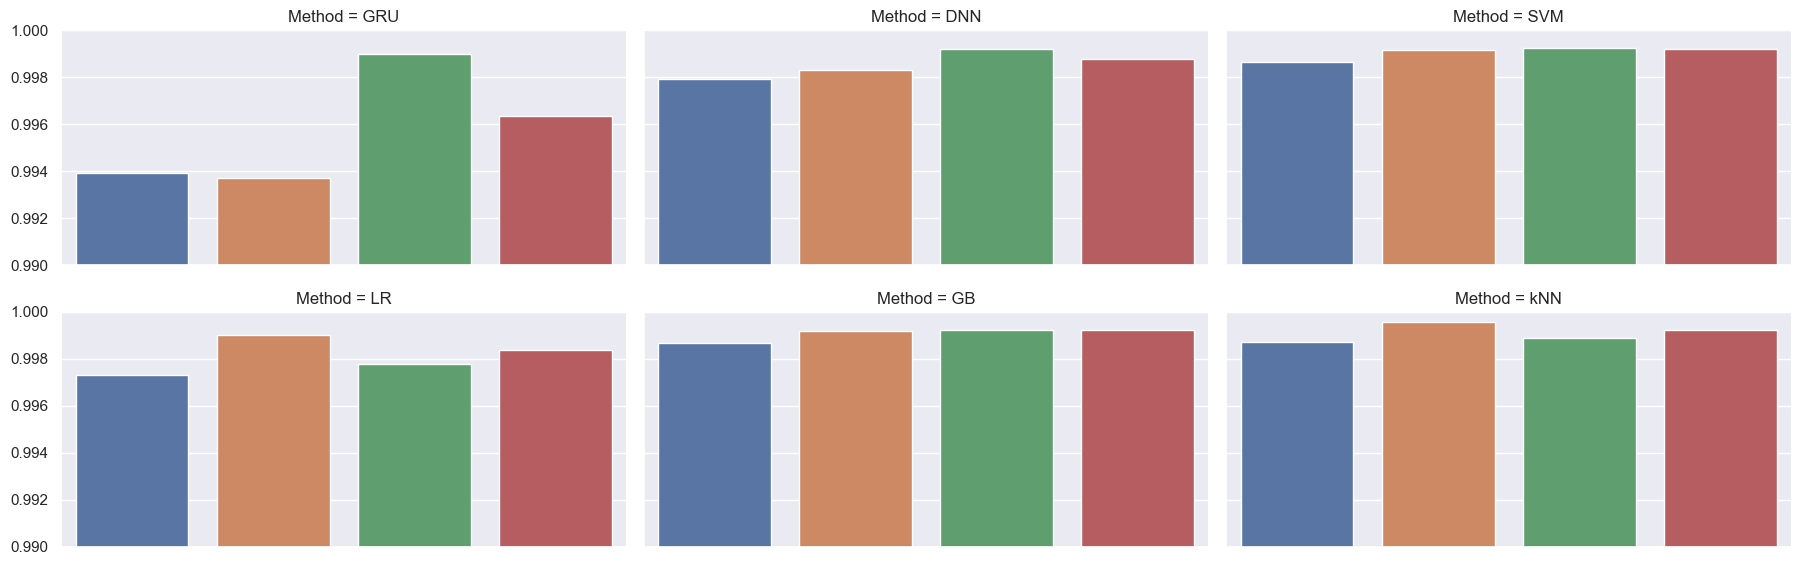

In [145]:
ax = sns.catplot(data=results.iloc[:,:5].query('Method != "LSTM" and Method != "CNN"'), col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.99,1))
ax.set_xticklabels(rotation=45)
ax = ax


> As observed, the evaluated methods achieved good performance outcomes close to 1. As the evaluated methods achieved similar outcomes, a more specific analysis should be performed.

Showing results of the LSTM and CNN methods.

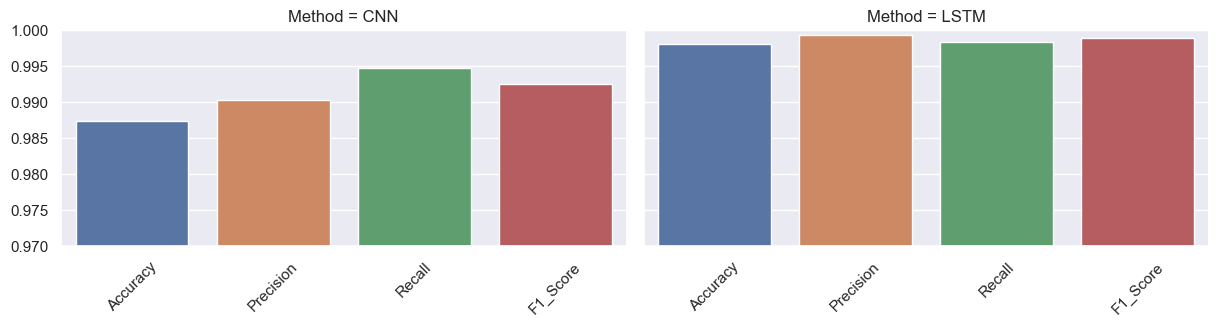

In [146]:
ax = sns.catplot(data=results.iloc[:,:5].query('Method == "LSTM" or Method == "CNN"'), col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97,1))
ax.set_xticklabels(rotation=45)
ax = ax

> CNN and LSTM fared worse between the tested approaches. However, these methods achieved performance metrics above 97%, which is a relatively good outcome. 

**Average of the Metrics**

Plotting the Average of the previously mentioned performance metrics to summarize the method's results. 

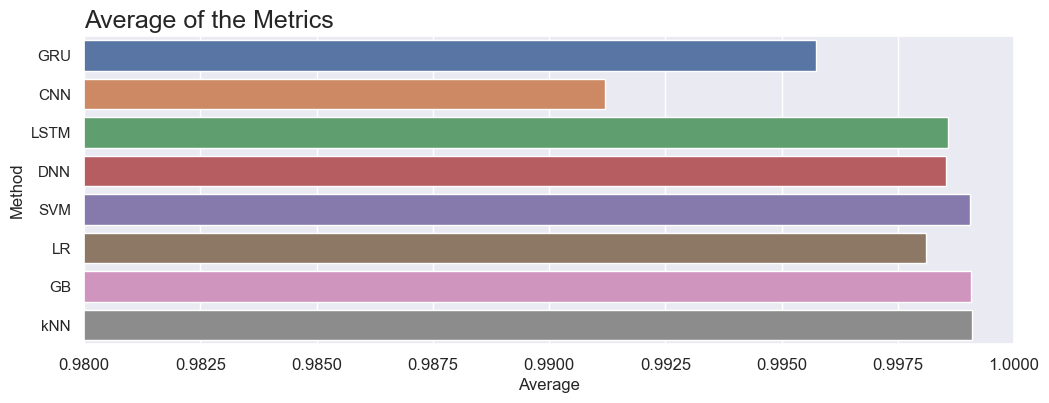

In [147]:
plt.figure(figsize=(12,4))
ax = sns.barplot(data=results, y='Method', x='Average')
ax.set(xlim=(0.98,1))
ax.set_title('Average of the Metrics', fontsize=18, loc='left')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax = ax

> As observed, on average, kNN fared slightly better compared to GB, LR, SVM, and GRU, which, in turn, achieved very similar results. However, these methods performed nearly 99.9%, which is considered a good classification outcome. 

**Detection rate of Normal and Attack flow records**

The following plot shows the results of each method for classifying normal and attack flow records.

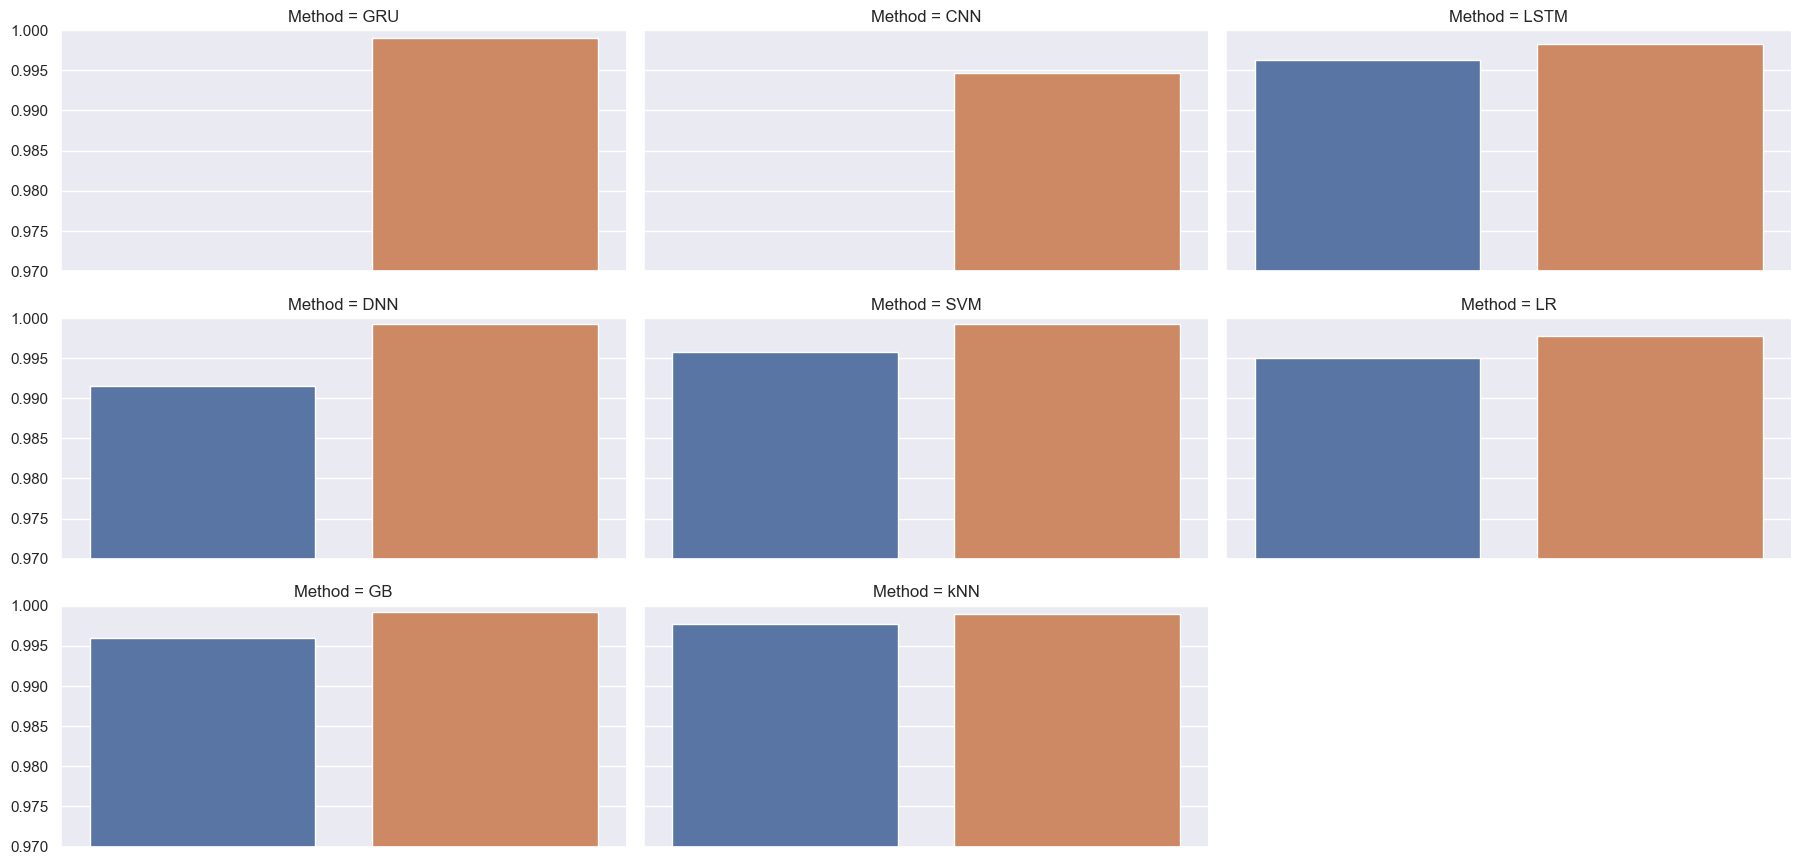

In [148]:
ax = sns.catplot(data=results[['Method', 'Normal_Detect_Rate', 'Atk_Detect_Rate']], col='Method', col_wrap=3, kind='bar', height=3, aspect=2)
ax.set(ylim=(0.97,1))
ax.set_xticklabels(rotation=45)
ax = ax


> kNN achieved the best classification outcomes. 

> GRU showed the most balanced approach regarding classifying normal and attack flows. 

> Although CNN achieved a relatively good classification of attacks, the classification of normal record flows was low compared to other methods. This result can explain the Accuracy rate of this method. This situation also occurs with the LSTM method, which achieved a good classification rate for normal flows and a low classification rate for attack ones. 